# Dissertation

Import relevant libraries, download, and prepare data.

In [1]:
#Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.varmax import VARMAX
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('dataset.csv')

In [3]:
data = data.drop(['Unnamed: 0', 'Unemployment Rate', 'Close_daily'], axis = 1)

In [4]:
data.describe()

,CPI,Close,Exp_Alcoholic_Beverages,GDP_per_capita
count,33.000000,33.000000,33.000000,33.000000
mean,2.470707,9822.117408,5462.878788,8048.121212
std,2.785313,11794.097884,801.404890,371.847983
min,0.000000,157.401499,4432.000000,6437.000000
25%,0.600000,649.980713,4677.000000,7976.000000
50%,1.866667,6129.906575,5466.000000,8156.000000
75%,2.733333,15256.224940,5840.000000,8246.000000
max,10.766667,40637.153650,7328.000000,8397.000000


In [5]:
data.corr()

,CPI,Close,Exp_Alcoholic_Beverages,GDP_per_capita
CPI,1.000000,0.470803,0.214360,0.346855
Close,0.470803,1.000000,0.640774,-0.028941
Exp_Alcoholic_Beverages,0.214360,0.640774,1.000000,-0.477600
GDP_per_capita,0.346855,-0.028941,-0.477600,1.000000


# Part I: Visualizations

# Standardize Data

The variables have different units, so they will be standardized using StandardScaler to plot on the same axes.

In [6]:
#Standardize data as they have different units
#Initiate standard scaler
scaler = StandardScaler()

#Fit transfor data
data_scaled = scaler.fit_transform(data.drop('Year', axis=1))

#Create DataFrame from scaled data
data_scaled = pd.DataFrame(data_scaled, columns=data.columns.drop('Year'))

#Add year column back to scaled data
data_scaled['Year'] = data['Year']

In [7]:
#Change 'Year' column into datetime format
data_scaled['Year'] = pd.to_datetime(data_scaled['Year'])

# 1.1 Plot CPI and Bitcoin Prices

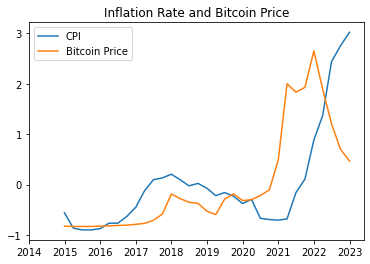

In [17]:
#Plot CPI and Bitcoin Price
plt.plot(data_scaled['Year'], data_scaled['CPI'], label='CPI')
plt.plot(data_scaled['Year'], data_scaled['Close'], label='Bitcoin Price')

#Extract unique years from the 'Year' column
unique_years = data_scaled['Year'].dt.year.unique()

#Add year 2023 into the plot
unique_years = np.append(unique_years, 2023)

#Convert unique years to datetime for start of each year
unique_years_dt = pd.to_datetime(unique_years, format='%Y')

#Set the x-ticks to show only unique years
plt.xticks(unique_years_dt, labels=unique_years)

#Set y-ticks
y_ticks = [-1, 0, 1, 2, 3]
plt.yticks(y_ticks)

plt.legend()
plt.title('Inflation Rate and Bitcoin Price')
plt.show()

# 1.2 Plot Alcohol Expenditure and GDP per capita

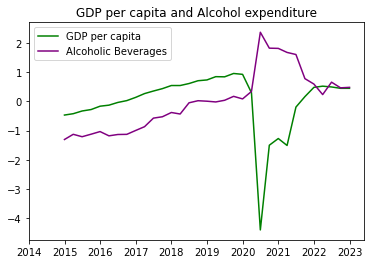

In [18]:
#Plot GDP per capita and Alcohol expenditures
plt.plot(data_scaled['Year'], data_scaled['GDP_per_capita'], label='GDP per capita', color='green')
plt.plot(data_scaled['Year'], data_scaled['Exp_Alcoholic_Beverages'], label='Alcoholic Beverages', color='purple')

#Extract unique years from the 'Year' column
unique_years = data_scaled['Year'].dt.year.unique()

#Add year 2023 into the plot
unique_years = np.append(unique_years, 2023)

#Convert unique years to datetime for start of each year
unique_years_dt = pd.to_datetime(unique_years, format='%Y')

#Set the x-ticks to show only unique years
plt.xticks(unique_years_dt, labels=unique_years)

plt.legend()
plt.title('GDP per capita and Alcohol expenditure')
plt.show()

# Part II: Manipulations for Time-series

# 2.1 ADF Test

Conduct ADF unit root test to check stationarity of data.

In [11]:
#Set year as index
data['Year'] = pd.to_datetime(data['Year'])
data.set_index('Year', inplace=True)

In [12]:
#Define function to get ADF test result
def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [13]:
#Get test results for each variable in the dataset
for column in data.columns:
    print(f"Results for column: {column}")
    adf_test(data[column])
    print("\n")

Results for column: CPI
ADF Statistic: -2.774217
p-value: 0.062052


Results for column: Close
ADF Statistic: 1.034645
p-value: 0.994618


Results for column: Exp_Alcoholic_Beverages
ADF Statistic: -1.514328
p-value: 0.526412


Results for column: GDP_per_capita
ADF Statistic: -3.178871
p-value: 0.021241




Only GDP per capita that is stationary at 5%, the other variables are non-stationary. I will proceed the data with differencing method to use the data for linear regression model.

# 2.2 Differencing Data

In [14]:
#Make a copy of the data
data_diff = data.copy()

In [15]:
#Select columns to use differencing
columns_diff = ['CPI', 'Close', 'Exp_Alcoholic_Beverages', 'GDP_per_capita']

#Create new columns
for column in columns_diff:
    data_diff[column + '_diff'] = data_diff[column].diff()

In [16]:
#Fill NA row after differencing with backward filling method
data_diff = data_diff.bfill()

In [17]:
#Get ADF test results for each variable in the dataset
for column in data_diff.columns:
    print(f"Results for column: {column}")
    adf_test(data_diff[column])
    print("\n")

Results for column: CPI
ADF Statistic: -2.774217
p-value: 0.062052


Results for column: Close
ADF Statistic: 1.034645
p-value: 0.994618


Results for column: Exp_Alcoholic_Beverages
ADF Statistic: -1.514328
p-value: 0.526412


Results for column: GDP_per_capita
ADF Statistic: -3.178871
p-value: 0.021241


Results for column: CPI_diff
ADF Statistic: -1.674943
p-value: 0.444067


Results for column: Close_diff
ADF Statistic: -3.628416
p-value: 0.005240


Results for column: Exp_Alcoholic_Beverages_diff
ADF Statistic: -6.071313
p-value: 0.000000


Results for column: GDP_per_capita_diff
ADF Statistic: -7.409871
p-value: 0.000000




In [27]:
data_diff.corr()

,CPI,Close,Exp_Alcoholic_Beverages,GDP_per_capita,CPI_diff,Close_diff,Exp_Alcoholic_Beverages_diff,GDP_per_capita_diff
CPI,1.000000,0.470803,0.214360,0.346855,0.633406,-0.445912,-0.102355,0.023935
Close,0.470803,1.000000,0.640774,-0.028941,0.637897,0.176116,-0.297954,0.108240
Exp_Alcoholic_Beverages,0.214360,0.640774,1.000000,-0.477600,0.163337,0.239591,0.144337,-0.134614
GDP_per_capita,0.346855,-0.028941,-0.477600,1.000000,0.322255,-0.314413,-0.549273,0.499432
CPI_diff,0.633406,0.637897,0.163337,0.322255,1.000000,-0.222300,-0.271667,0.268546
Close_diff,-0.445912,0.176116,0.239591,-0.314413,-0.222300,1.000000,-0.036028,-0.018579
Exp_Alcoholic_Beverages_diff,-0.102355,-0.297954,0.144337,-0.549273,-0.271667,-0.036028,1.000000,-0.832565
GDP_per_capita_diff,0.023935,0.108240,-0.134614,0.499432,0.268546,-0.018579,-0.832565,1.000000


# Part III: ARIMA

ARIMA model does not require data to be stationary, so I will use 'data' dataset.

In [19]:
#Year index has quarterly data started in December
data.index.freq = 'Q-DEC'

# 3.1 Find Optimal ARIMA Model for CPI and GDP per capita

The criteria of the optimal model is to minimize AIC. There is no clear sign of seasonality in the line plots, so I set it as no seasonal effect.

In [21]:
#Use auto_arima to find optimal ARIMA model
#m=4 as it is quarterly data
arima_cpi = pm.auto_arima(data['CPI'], seasonal=False, m=4, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=79.782, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=70.502, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=76.433, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=82.283, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=65.484, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=66.051, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=67.087, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=69.172, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=63.908, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=69.555, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=64.506, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=65.508, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=67.751, Time=0.02 sec
 AR

In [22]:
arima_income = pm.auto_arima(data['GDP_per_capita'], seasonal=False, m=4, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=496.382, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=689.269, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=494.501, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=492.833, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=482.353, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=482.053, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=487.254, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=483.182, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=480.213, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=482.162, Time=0.01 sec
 A

# 3.2 Run ARIMA based on optimal models

In [27]:
#Divide data into train and test sets
arima_train = data.iloc[:-6]
arima_test = data.iloc[-6:]

In [33]:
#Define function to get MAPE for prediction accuracy
def MAPE(y_true, y_pred): 
    #Convert data to numpy array
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    #Avoid division by zero
    #mask = y_true != 0
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 3.2.1 ARIMA for CPI

In [28]:
#Fit ARIMA model on train set
model_cpi = ARIMA(arima_train['CPI'], order=(4,1,0))
fit_cpi = model_cpi.fit()

In [29]:
#Predict test set
start = len(arima_train)
end = len(arima_train) + len(arima_test) - 1
predictions1 = fit_cpi.predict(start=start, end=end, typ='levels').values

In [31]:
#Extract actual values of test set
y_test_cpi = arima_test['CPI'].values

In [34]:
mape_cpi = MAPE(y_test_cpi, predictions1)
accuracy_cpi = 100 - mape_cpi
print(f"Accuracy based on MAPE: {accuracy_cpi: .2f}%")

Accuracy based on MAPE:  55.64%


# 3.2.2 ARIMA for GDP per capita

In [36]:
#Fit ARIMA model on train set
model_income = ARIMA(arima_train['GDP_per_capita'], order=(1,0,0))
fit_income = model_income.fit()

In [37]:
#Predict test set
predictions2 = fit_income.predict(start=start, end=end, typ='levels').values

In [38]:
#Extract actual values of test set
y_test_income = arima_test['GDP_per_capita'].values

In [39]:
mape_income = MAPE(y_test_income, predictions2)
accuracy_income = 100 - mape_income
print(f"Accuracy based on MAPE: {accuracy_income: .2f}%")

Accuracy based on MAPE:  97.62%


# Part IV: Extract Actual Values of Each Process According To ARIMA Optimal Models

# 4.1 Retrieve Values from Autoregressive Process

There are only AR process to be retrieved the values. The optimal ARIMA models for CPI and GDP per capita do not have MA process.

In [40]:
#Extract AR coefficients
ar_coeff_cpi = fit_cpi.arparams
ar_coeff_income = fit_income.arparams

In [41]:
#Define function to get actual values of AR from CPI data
def get_ar(series, ar_coeff):
    ar_values = pd.Series(index=series.index)
    p = len(ar_coeff)
    for t in range(p, len(series)):
        ar_value = sum([ar_coeff[i] * series.iloc[t - (i + 1)] for i in range(p)])
        ar_values.iloc[t] = ar_value
    return ar_values

In [42]:
#Retrieve AR from CPI data
ar_cpi = get_ar(data[['CPI']], ar_coeff_cpi)

#Convert to DataFrame
ar_cpi = pd.DataFrame(ar_cpi)

#Change column name
ar_cpi = ar_cpi.rename(columns={0: 'CPI_ar'})

In [43]:
#Retrieve AR from GDP per capita data
ar_income = get_ar(data[['GDP_per_capita']], ar_coeff_income)

#Convert to DataFrame
ar_income = pd.DataFrame(ar_income)

#Change column name
ar_income = ar_income.rename(columns={0: 'Income_ar'})

#Join datasets together
data_diff = data_diff.join([ar_cpi, ar_income], how='outer')

Since there are missing values after generating derivatives and AR process, I will use bfill to fill missing values.

In [45]:
data_diff = data_diff.bfill()

# 4.2 Pearson Correlations

In [87]:
correlation_matrix = data_diff[['CPI', 'Close', 'GDP_per_capita', 'Exp_Alcoholic_Beverages', 'CPI_diff', 'CPI_ar', 'Income_ar']].corr()

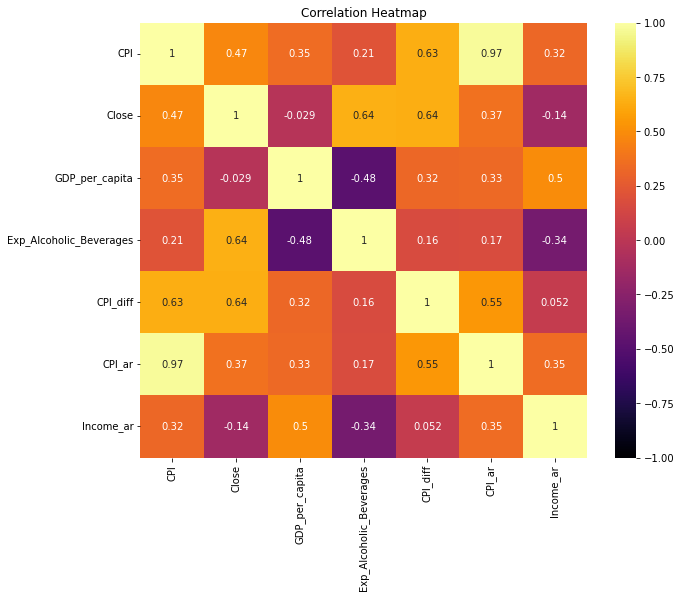

In [92]:
#Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Part V: Linear Regression Models

In order to make predictions based on Linear Regression model, I set the first quarter in December and split the data into train and test sets. The test set contains the last 6 quarters of the data.

In [58]:
#Year index has quarterly data started in December
data_diff.index.freq = 'Q-DEC'

In [59]:
#Split data into train and test sets
train = data_diff.iloc[:-6]
test = data_diff.iloc[-6:]

# 5.1.1 Prediction of CPI on Bitcoin Price

In [60]:
#Filter data for first model
x1_train = train[['CPI_diff', 'CPI_ar']]
y1_train = train['Close']
x1_test = test[['CPI_diff', 'CPI_ar']]
y1_test = test['Close']

In [61]:
#Add constant to train data
x1_train_const = sm.add_constant(x1_train)

#Fit linear regression model
model1_pred = sm.OLS(y1_train, x1_train_const).fit()

#Add constant to test data
x1_test_const = sm.add_constant(x1_test)

#Predict test set
y1_pred = model1_pred.predict(x1_test_const)

In [62]:
mape1 = MAPE(y1_test, y1_pred)
accuracy1 = 100 - mape1
print(f"Accuracy based on MAPE: {accuracy1: .2f}%")

Accuracy based on MAPE:  27.53%


# 5.1.2 Full model

In [80]:
#Get target and predictor variables from the dataset
x1 = data_diff[['CPI_diff', 'CPI_ar']]
y1 = data_diff['Close']

In [81]:
#Add constant to a matrix
x1 = sm.add_constant(x1)

#Fit linear regression model
model1 = sm.OLS(y1, x1).fit()

In [82]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     10.32
Date:                Sat, 19 Aug 2023   Prob (F-statistic):           0.000390
Time:                        12:32:06   Log-Likelihood:                -347.07
No. Observations:                  33   AIC:                             700.1
Df Residuals:                      30   BIC:                             704.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7183.6415   1866.756      3.848      0.001    3371.217     1.1e+04
CPI_diff    9003.8940   2425.656      3.712      0.001    4050.043     1.4e+04
CPI_ar       245.7392   1447.545      0.170      0.866   -2710.543    3202.021
==============================================================================
Omnibus:                        5.412   Durbin-Watson:                   0.648
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                4.017
Skew:                           0.820   Prob(JB):                        0.134
Kurtosis:                       3.480   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 5.2.1 Prediction of GDP per capita on Alcohol Expenditure

In [63]:
#Filter data for first model
x2_train = train['Income_ar']
y2_train = train['Exp_Alcoholic_Beverages']
x2_test = test['Income_ar']
y2_test = test['Exp_Alcoholic_Beverages']

In [64]:
#Add constant to train data
x2_train_const = sm.add_constant(x2_train)

#Fit linear regression model
model2_pred = sm.OLS(y2_train, x2_train_const).fit()

#Add constant to test data
x2_test_const = sm.add_constant(x2_test)

#Predict test set
y2_pred = model2_pred.predict(x2_test_const)

In [65]:
mape2 = MAPE(y2_test, y2_pred)
accuracy2 = 100 - mape2
print(f"Accuracy based on MAPE: {accuracy2: .2f}%")

Accuracy based on MAPE:  89.08%


# 5.2.2 Full model

In [83]:
#Get target and predictor variables from the dataset
x2 = data_diff['Income_ar']
y2 = data_diff['Exp_Alcoholic_Beverages']

In [84]:
#Add constant to a matrix
x2 = sm.add_constant(x2)

#Fit linear regression model
model2 = sm.OLS(y2, x2).fit()

In [85]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     Exp_Alcoholic_Beverages   R-squared:                       0.119
Model:                                 OLS   Adj. R-squared:                  0.090
Method:                      Least Squares   F-statistic:                     4.183
Date:                     Sat, 19 Aug 2023   Prob (F-statistic):             0.0494
Time:                             12:34:11   Log-Likelihood:                -264.88
No. Observations:                       33   AIC:                             533.8
Df Residuals:                           31   BIC:                             536.8
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.144e+04   2923.676      3.912      0.000    5473.684    1.74e+04
Income_ar     -1.6016      0.783     -2.045      0.049      -3.199      -0.005
==============================================================================
Omnibus:                        0.306   Durbin-Watson:                   0.342
Prob(Omnibus):                  0.858   Jarque-Bera (JB):                0.409
Skew:                           0.201   Prob(JB):                        0.815
Kurtosis:                       2.633   Cond. No.                     8.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""